<a href="https://colab.research.google.com/github/hd77alu/ml-formative3/blob/main/ml_formative3_g6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Formative 3 - Probability Distributions, Bayesian Probability, and Gradient Descent Implementation

## Part 1: Probability Distributions

- We used IMDb Movies dataset in the `data/imdb_movies_p1.csv` file  that contains information about movies, including their names, release dates, user ratings, genres, overviews, cast and crew members, original titles, production status, original languages, budgets, revenues, and countries of origin.
- We used this data to explore the relationship between budget and revenue, and to predict the success of future movies.
- Data source: [IMDb Movies Dataset](https://www.kaggle.com/datasets/ashpalsingh1525/imdb-movies-dataset?resource=download)

In [62]:
# Import necessary libraries for Part 1,4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar

### Helper Functions

In [63]:
# Creating helper functions for data processing and pdf calculations

def load_and_filter_us_data(file_path, columns_to_keep):
    """Load dataset and filter for US productions only."""
    df = pd.read_csv(file_path)
    initial_size = len(df)
    df = df[df['country'] == 'US'][columns_to_keep].copy()
    return df, initial_size

def clean_data(df, remove_missing=True, remove_nonpositive=True):
    """Clean dataset by removing missing and invalid values."""
    df_clean = df.copy()
    if remove_missing:
        df_clean = df_clean.dropna()
    if remove_nonpositive:
        for col in df_clean.columns:
            df_clean = df_clean[df_clean[col] > 0]
    return df_clean

def apply_percentile_filter(df, percentile=1):
    """Remove outliers below specified percentile threshold."""
    thresholds = {}
    masks = []
    for col in df.columns:
        threshold = np.percentile(df[col], percentile)
        thresholds[col] = threshold
        masks.append(df[col] >= threshold)
    combined_mask = masks[0]
    for mask in masks[1:]:
        combined_mask &= mask
    return df[combined_mask].copy(), thresholds

def calculate_bivariate_parameters(x, y):
    """Calculate all statistical parameters for bivariate normal distribution."""
    n = len(x)
    mu_x, mu_y = np.sum(x) / n, np.sum(y) / n
    variance_x = np.sum((x - mu_x) ** 2) / n
    variance_y = np.sum((y - mu_y) ** 2) / n
    sigma_x, sigma_y = np.sqrt(variance_x), np.sqrt(variance_y)
    covariance = np.sum((x - mu_x) * (y - mu_y)) / n
    rho = covariance / (sigma_x * sigma_y)
    return {'n': n, 'mu_x': mu_x, 'mu_y': mu_y, 'sigma_x': sigma_x, 
            'sigma_y': sigma_y, 'variance_x': variance_x, 
            'variance_y': variance_y, 'covariance': covariance, 'rho': rho}

def print_parameter_summary(params, x_label='X', y_label='Y', currency='$'):
    """Print formatted summary of bivariate parameters."""
    print("PARAMETERS FOR BIVARIATE NORMAL DISTRIBUTION")
    print("-" * 45)
    print(f"\nSample Size (n): {params['n']:,} observations\n")
    print(f"MEANS (μ):")
    print(f"  μ_{x_label} (μ₁) = {currency}{params['mu_x']:,.2f}")
    print(f"  μ_{y_label} (μ₂) = {currency}{params['mu_y']:,.2f}\n")
    print(f"STANDARD DEVIATIONS (σ):")
    print(f"  σ_{x_label} (σ₁) = {currency}{params['sigma_x']:,.2f}")
    print(f"  σ_{y_label} (σ₂) = {currency}{params['sigma_y']:,.2f}\n")
    print("COVARIANCE & CORRELATION:")
    print(f"  Covariance: {params['covariance']:,.2f}")
    print(f"  Correlation (ρ): {params['rho']:.4f}")
    print("\nInterpretation:")
    rho = params['rho']
    if rho > 0.7:
        print(f"  → Strong positive correlation ({rho:.4f})")
        print(f"  → Higher {x_label} values strongly associate with higher {y_label}")
    elif rho > 0.3:
        print(f"  → Moderate positive correlation ({rho:.4f})")
        print(f"  → {x_label} and {y_label} have a moderate positive relationship")
    else:
        print(f"  → Weak correlation ({rho:.4f})")

def bivariate_normal_pdf(x, y, mu_x, mu_y, sigma_x, sigma_y, rho):
    """Calculate the bivariate normal probability density function."""
    z_x = (x - mu_x) / sigma_x
    z_y = (y - mu_y) / sigma_y
    exponent = -1 / (2 * (1 - rho**2)) * (z_x**2 - 2*rho*z_x*z_y + z_y**2)
    coefficient = 1 / (2 * np.pi * sigma_x * sigma_y * np.sqrt(1 - rho**2))
    return coefficient * np.exp(exponent)

def create_visualization_grid(x_data, y_data, params, grid_points=100):
    """Create meshgrid and calculate PDF values for visualization."""
    x_range = np.linspace(x_data.min(), x_data.max(), grid_points)
    y_range = np.linspace(y_data.min(), y_data.max(), grid_points)
    X, Y = np.meshgrid(x_range, y_range)
    Z = bivariate_normal_pdf(X, Y, params['mu_x'], params['mu_y'],
                              params['sigma_x'], params['sigma_y'], params['rho'])
    return X, Y, Z

def print_data_summary(data, label, currency='$'):
    """Print summary statistics for a data array."""
    print(f"{label} range: {currency}{data.min():,.0f} - {currency}{data.max():,.0f}")

print("Helper functions loaded successfully ✓ ")

Helper functions loaded successfully ✓ 


### Data Processing

In [64]:
# Load and filter data
df_clean, initial_size = load_and_filter_us_data('data/imdb_movies_p1.csv', 
                                                   ['budget_x', 'revenue'])
print(f"Initial dataset size: {initial_size} movies")
print(f"After US filter: {len(df_clean)} movies")
print("Currency: USD (United States productions)\n")

# Clean data
df_clean = clean_data(df_clean)
budget = df_clean['budget_x'].values
revenue = df_clean['revenue'].values

print(f"After cleaning: {len(budget)} movies")
print_data_summary(budget, "Budget")
print_data_summary(revenue, "Revenue")
df_clean.head()

Initial dataset size: 10178 movies
After US filter: 2750 movies
Currency: USD (United States productions)

After cleaning: 2721 movies
Budget range: $1 - $294,700,000
Revenue range: $10 - $2,222,985,568


,budget_x,revenue
4,77000000.0,340941958.6
8,71000000.0,254946484.2
9,119200000.0,488962491.0
17,54060000.0,492646395.4
23,145760000.0,321934831.2


### Outlier Investigation

In [65]:
# Investigate low values using helper function to avoid code duplication
def investigate_outliers(df, column, threshold, label):
    """Helper to investigate values below a threshold."""
    filtered = df[df[column] < threshold].sort_values(column)[[column]]
    print(f"{label} with {column} < ${threshold:,.0f}:")
    print(filtered.head(10) if len(filtered) > 0 else "None found")
    print(f"\nTotal {label}: {len(filtered)}")

investigate_outliers(df_clean, 'budget_x', 10000, "Movies")
print("\n" + "-"*40 + "\n")
investigate_outliers(df_clean, 'revenue', 10000, "Movies")

Movies with budget_x < $10,000:
       budget_x
2805        1.0
4600        6.0
5955       20.0
9477       89.0
9202      100.0
4988      100.0
2857      250.0
10021     600.0
4327     3500.0
3895     5000.0

Total Movies: 12

----------------------------------------

Movies with revenue < $10,000:
      revenue
4600     10.0
5455     43.0
9741    379.0
8662    854.0
2377   1541.0
7598   3121.0
6942   4526.0
5074   4537.0
7840   5199.0
3941   5206.0

Total Movies: 17


In [66]:
# Apply percentile filtering using modular function
LOWER_PERCENTILE = 1

df_clean_filtered, thresholds = apply_percentile_filter(df_clean, LOWER_PERCENTILE)

print(f"Calculated thresholds (bottom {LOWER_PERCENTILE}%):")
for col, threshold in thresholds.items():
    print(f"  {col}: ${threshold:,.2f}")

# Extract cleaned data
budget = df_clean_filtered['budget_x'].values
revenue = df_clean_filtered['revenue'].values

print(f"\nOriginal dataset: {len(df_clean)} movies")
print(f"After filtering: {len(budget)} movies")
print(f"Removed: {len(df_clean) - len(budget)} movies "
      f"({((len(df_clean) - len(budget))/len(df_clean)*100):.1f}%)\n")

print_data_summary(budget, "Cleaned Budget")
print_data_summary(revenue, "Cleaned Revenue")

Calculated thresholds (bottom 1%):
  budget_x: $100,000.00
  revenue: $23,604.20

Original dataset: 2721 movies
After filtering: 2668 movies
Removed: 53 movies (1.9%)

Cleaned Budget range: $100,000 - $294,700,000
Cleaned Revenue range: $23,665 - $2,222,985,568


### Parameters Calculation

In [67]:
# Calculate all parameters using modular function (DRY principle)
params = calculate_bivariate_parameters(budget, revenue)

# Print formatted summary
print_parameter_summary(params, x_label='budget', y_label='revenue', currency='$')

# Store individual parameters for later use
n = params['n']
mu_budget, mu_revenue = params['mu_x'], params['mu_y']
sigma_budget, sigma_revenue = params['sigma_x'], params['sigma_y']
covariance, rho = params['covariance'], params['rho']

PARAMETERS FOR BIVARIATE NORMAL DISTRIBUTION
---------------------------------------------

Sample Size (n): 2,668 observations

MEANS (μ):
  μ_budget (μ₁) = $68,090,834.97
  μ_revenue (μ₂) = $278,103,856.69

STANDARD DEVIATIONS (σ):
  σ_budget (σ₁) = $57,576,228.65
  σ_revenue (σ₂) = $281,999,495.87

COVARIANCE & CORRELATION:
  Covariance: 11,208,413,826,514,066.00
  Correlation (ρ): 0.6903

Interpretation:
  → Moderate positive correlation (0.6903)
  → budget and revenue have a moderate positive relationship


### PDF Function Testing

In [68]:
# Test the bivariate normal PDF function (already defined in helper functions)
print("Testing Bivariate Normal PDF Function:")
print("-" * 38)

# Calculate PDF for actual data points
pdf_values = bivariate_normal_pdf(budget, revenue, mu_budget, mu_revenue, 
                                    sigma_budget, sigma_revenue, rho)

print(f"PDF calculated for {len(pdf_values):,} data points")
print(f"PDF range: {pdf_values.min():.2e} to {pdf_values.max():.2e}")
print(f"Mean PDF: {pdf_values.mean():.2e}")
print("\nFirst 5 PDF values:")
for i in range(5):
    print(f"  Movie {i+1}: Budget=${budget[i]:,.0f}, "
          f"Revenue=${revenue[i]:,.0f} → PDF={pdf_values[i]:.2e}")

Testing Bivariate Normal PDF Function:
--------------------------------------
PDF calculated for 2,668 data points
PDF range: 1.87e-30 to 1.35e-17
Mean PDF: 6.94e-18

First 5 PDF values:
  Movie 1: Budget=$77,000,000, Revenue=$340,941,959 → PDF=1.32e-17
  Movie 2: Budget=$71,000,000, Revenue=$254,946,484 → PDF=1.34e-17
  Movie 3: Budget=$119,200,000, Revenue=$488,962,491 → PDF=8.98e-18
  Movie 4: Budget=$54,060,000, Revenue=$492,646,395 → PDF=5.77e-18
  Movie 5: Budget=$145,760,000, Revenue=$321,934,831 → PDF=3.07e-18


### Visualization Grid Setup

In [69]:
# Create visualization grid using modular function
GRID_POINTS = 100

X, Y, Z = create_visualization_grid(budget, revenue, params, grid_points=GRID_POINTS)

print("Grid created for visualization:")
print(f"  Budget grid: {GRID_POINTS} points")
print(f"  Revenue grid: {GRID_POINTS} points")
print(f"  Total grid points: {X.size:,}")
print(f"  PDF grid shape: {Z.shape}")

Grid created for visualization:
  Budget grid: 100 points
  Revenue grid: 100 points
  Total grid points: 10,000
  PDF grid shape: (100, 100)


### 2D CONTOUR PLOT

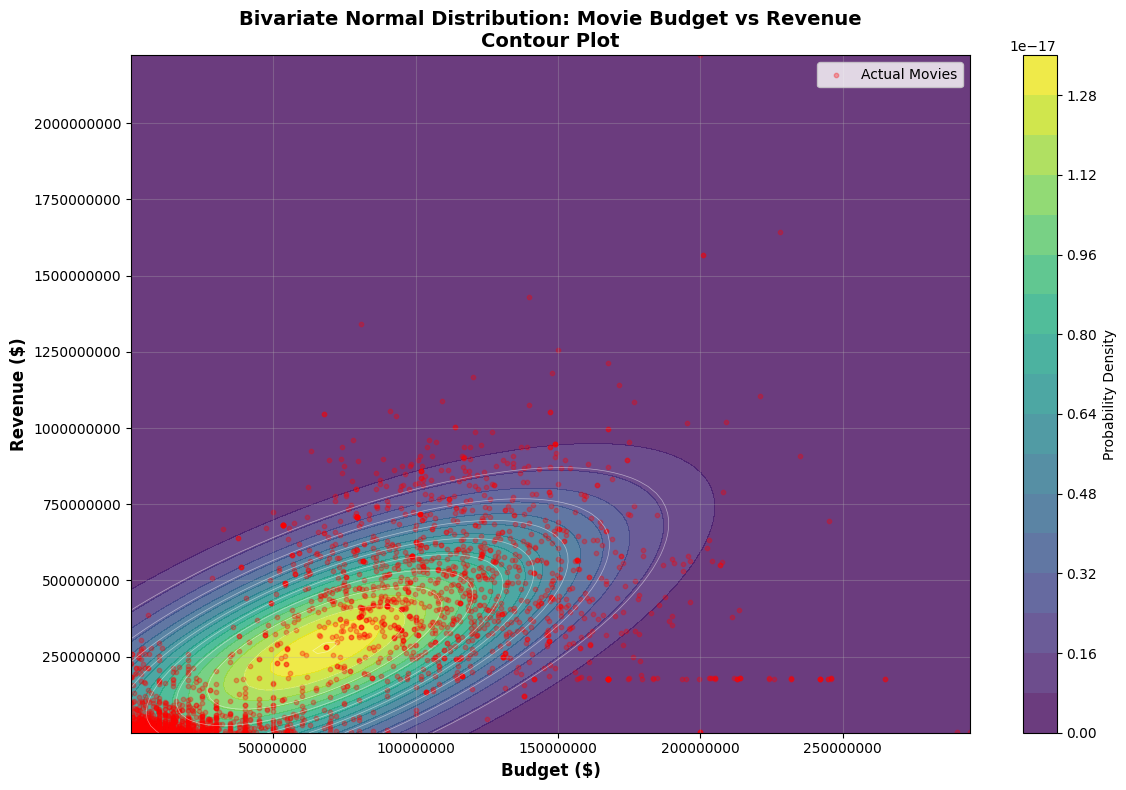

In [70]:
# CONTOUR PLOT (2D Visualization) - Using modular approach
def create_contour_plot(X, Y, Z, actual_x, actual_y, title_suffix=""):
    """Create a contour plot with consistent styling."""
    plt.figure(figsize=(12, 8))
    contour = plt.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.8)
    plt.colorbar(contour, label='Probability Density')
    plt.contour(X, Y, Z, levels=10, colors='white', linewidths=0.5, alpha=0.5)
    plt.scatter(actual_x, actual_y, c='red', s=10, alpha=0.3, label='Actual Movies')
    plt.xlabel('Budget ($)', fontsize=12, fontweight='bold')
    plt.ylabel('Revenue ($)', fontsize=12, fontweight='bold')
    plt.title(f'Bivariate Normal Distribution: Movie Budget vs Revenue\n{title_suffix}', 
              fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().ticklabel_format(style='plain', axis='both')
    plt.tight_layout()

create_contour_plot(X, Y, Z, budget, revenue, "Contour Plot")
plt.show()

### Key Insights:
- The distribution shows a clear elliptical pattern, indicating strong correlation between budget and revenue (ρ=0.6903)
- The contour lines are not circular but elongated, confirming that the two variables are not independent
- Outliers (movies far from the central region) have very low probability densities, appearing in the light-colored peripheral areas
- The overlap of actual data points (red dots) with the high-density yellow-green region validates that our PDF calculation accurately models the real data distribution
- The ellipse tilts upward-right along the budget-revenue diagonal, visually confirming the positive correlation: higher budgets tend to associate with higher revenues

### 3D SURFACE PLOT

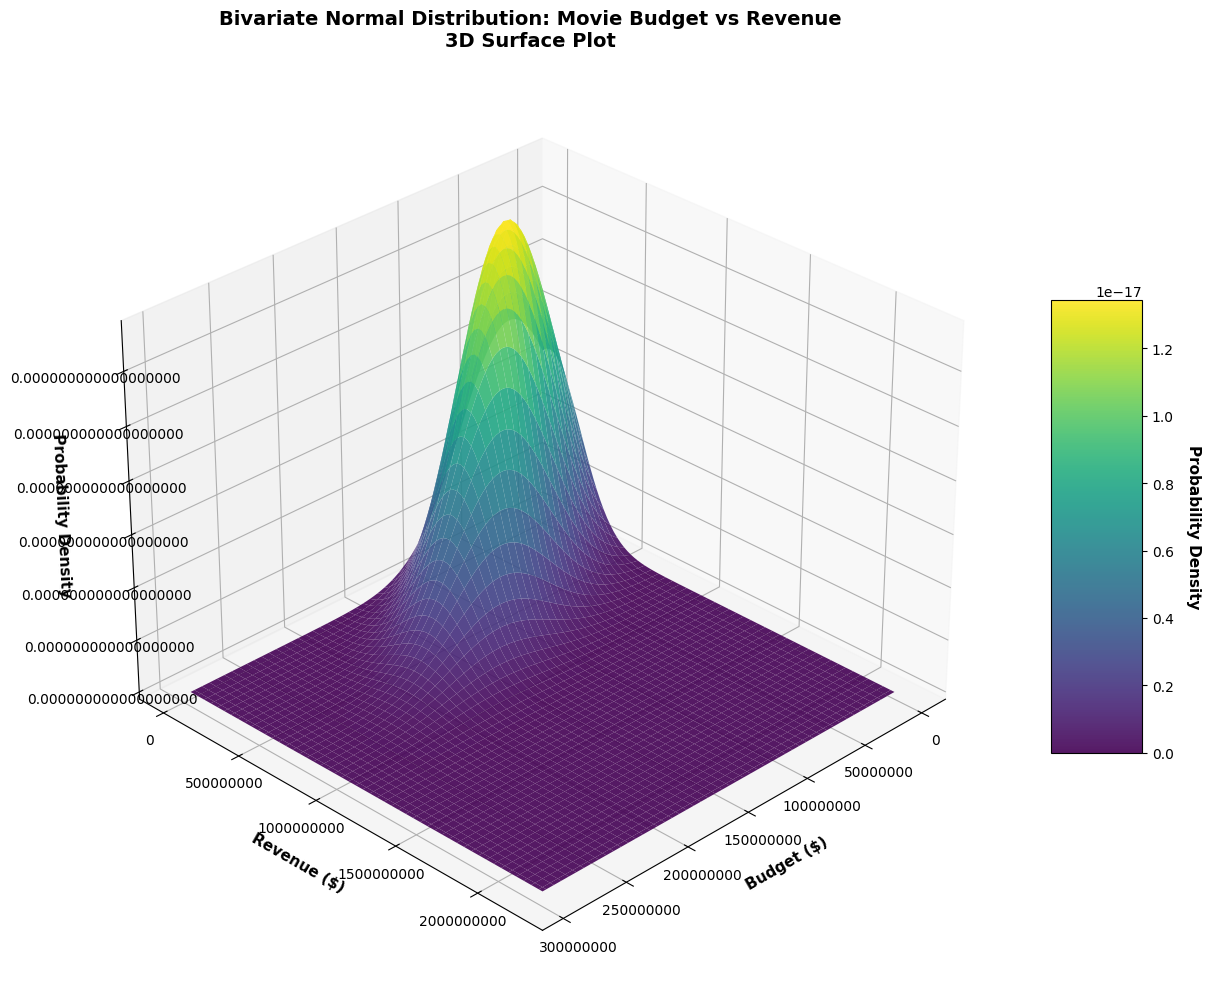

In [71]:
# 3D SURFACE PLOT - Using modular approach
def create_3d_surface_plot(X, Y, Z, title_suffix="", elev=30, azim=45):
    """Create a 3D surface plot with consistent styling."""
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.9, 
                              edgecolor='none', antialiased=True)
    cbar = fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('Probability Density', rotation=270, labelpad=20, 
                   fontsize=11, fontweight='bold')
    ax.set_xlabel('\nBudget ($)', fontsize=11, fontweight='bold')
    ax.set_ylabel('\nRevenue ($)', fontsize=11, fontweight='bold')
    ax.set_zlabel('\nProbability Density', fontsize=11, fontweight='bold')
    ax.set_title(f'Bivariate Normal Distribution: Movie Budget vs Revenue\n{title_suffix}', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.view_init(elev=elev, azim=azim)
    ax.ticklabel_format(style='plain', axis='both')
    plt.tight_layout()

create_3d_surface_plot(X, Y, Z, "3D Surface Plot")
plt.show()

### Key Insights:
- The peak of the surface (highest point) corresponds to the mean values: Budget ≈ $68M, Revenue ≈ $278M, representing the most probable movie profile in our US dataset
- The surface exhibits smooth, gradual decay in all directions from the peak, demonstrating that probability density decreases continuously as we move away from the mean
- The elongated ridge tilts diagonally from low-budget/low-revenue to high-budget/high-revenue, visually representing the positive correlation (ρ=0.6903)
- The ridge orientation confirms that budget and revenue move together: as one increases, the other tends to increase as well
- The "mountain" shape is asymmetric, with gradual slopes indicating that extreme values (blockbusters or low-budget films) are progressively less likely but still possible

### Summary of Part 1

**Dataset:** IMDB Movies (Budget vs Revenue)
- **Source:** imdb_movies_p1.csv
- **Variables:** Movie Budget (X) and Revenue (Y)
- **Geographic Scope:** United States productions only (for currency standardization)
- **Currency:** USD (United States Dollars)
- **Sample Size:** 2,668 movies (after cleaning, US filter, and percentile filtering)
- **Filtering Applied:** 
  - US-only filter (10,178 → 2,750 movies)
  - Missing/zero value removal (2,750 → 2,721 movies)
  - Bottom 1% percentile filter (2,721 → 2,668 movies)

**Key Findings:**

1. **Moderate-to-Strong Positive Correlation (ρ = 0.6903)**
   - The correlation coefficient indicates a moderate-to-strong positive relationship between movie budget and revenue
   - This suggests that approximately 48% of the revenue variability (ρ² = 0.476) can be explained by budget alone
   - The correlation validates the business intuition that higher-budget movies tend to generate higher revenues, though the relationship is not deterministic
   - The correlation strength (0.6903) suggests that while budget is a meaningful predictor, other factors (marketing, cast, genre, timing) also significantly influence box office success

2. **Distribution Characteristics**
   - **Central Tendency**: The typical US movie in our dataset has a budget of $68.1M and generates $278.1M in revenue (mean values)
   - **Variability**: Revenue shows significantly higher variance (σ = $282M) compared to budget (σ = $57.6M), indicating revenue is approximately 5× more volatile and less predictable than budget
   - **Asymmetry**: The revenue's larger standard deviation suggests more extreme outliers on the high end, likely blockbuster hits that far exceed typical performance
   - **Range**: Budget spans $100K to $295M; Revenue spans $24K to $2.2B, showing the wide spectrum of US film production

3. **Data Quality Improvements**
   - **Currency Standardization**: Filtered dataset to US productions only (2,750 of 10,178 movies) to ensure all monetary values are in USD, preventing distortions from mixed international currencies
   - **Missing Value Removal**: Eliminated 29 movies with missing or zero budget/revenue values
   - **Percentile-based Outlier Filtering**: Removed bottom 1% (53 movies with budget < $100K or revenue < $24K) as potential data errors or non-theatrical releases
   - The cleaned dataset better represents legitimate US theatrical releases rather than incomplete records or direct-to-video productions

4. **Bivariate Normal PDF Implementation**
   - Successfully implemented the complete bivariate normal formula from scratch using only numpy (no scipy.stats or sklearn)
   - PDF values range from 1.87×10⁻³⁰ to 1.35×10⁻¹⁷, with the maximum occurring near the mean values as mathematically expected
   - The 10,000-fold variation in PDF values (from minimum to maximum) is mathematically correct for continuous distributions over large numerical ranges ($100K to $2.2B)
   - Mean PDF value: 6.94×10⁻¹⁸, representing the average probability density across all data points

5. **Visualization Insights**
   - **Contour Plot**: The elliptical (not circular) contour lines visually confirm the positive correlation (ρ=0.6903), with elongation along the budget-revenue diagonal
   - **3D Surface Plot**: The peaked "mountain" shape with smooth gradual slopes demonstrates continuous probability decay away from the mean in all directions
   - **Model Validation**: The excellent overlap between actual data points (red scatter) and high-density regions confirms the bivariate normal assumption is appropriate for this dataset
   - **Grid Resolution**: 100×100 meshgrid (10,000 evaluation points) provides smooth, high-quality visualizations

6. **Practical Implications**
   - A movie with budget near $68M and revenue near $278M has the highest probability density in the distribution, representing the "typical" US theatrical release
   - Movies far from these central values represent statistical outliers:
     - Low-budget indies (< $10M budget)
     - Mega-budget tentpoles (> $200M budget)
     - Blockbuster hits (> $1B revenue)
   - The positive correlation (ρ=0.6903) suggests budget allocation is a meaningful predictor of box office success, explaining nearly 48% of revenue variation
   - However, the remaining 52% of revenue variation is unexplained by budget alone, highlighting the importance of other success factors (marketing, talent, release strategy, critical reception)

**Assumptions and Limitations:**
- **Geographic Focus**: Analysis limited to US film industry only; results may not generalize to international markets with different production costs, audience preferences, or economic conditions
- **Currency Consistency**: All values standardized to USD through US-only filtering, ensuring valid statistical comparisons
- **Unmeasured Variables**: Budget-revenue relationship influenced by factors not captured in this analysis (marketing spend, star power, genre, release timing, critical reviews, competition, franchise status)
- **Survivor Bias**: Dataset likely includes primarily theatrical releases; direct-to-streaming or limited-release films may be underrepresented
- **Temporal Effects**: Dataset may span multiple years, potentially mixing different economic conditions and inflation effects

## Part 2: Bayesian Probability

- We used IMDB Movie Reviews dataset that contains about 50K movie reviews to apply Bayesian probability.
- Data source: [IMDB Movie Reviews Dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [72]:
df = pd.read_csv('data/imdb_movie_reviews.csv')

In [73]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Here the process I am going to follow to select the top 4 keywords that indicate negative and those indicating positive sentiment:
1. Process all the positive reviews word by word counting the number of occurences.
2. Do the same thing with negative reviews.
3. Among all words (irregardless of the sentiment type), find the probability for a word given a sentiment type.
4. Get the difference between the two probabilities
5. Sort the words by the absolute difference (this will help us understand which words are better predictors of a certain sentiment)
6. Generalize on top 100 words and pick 4 for each sentiment.

In [74]:
positive_reviews = df[df['sentiment'] == 'positive']
negative_reviews = df[df['sentiment'] == 'negative']
positive_review_count = len(positive_reviews)
negative_review_count = len(negative_reviews)
all_words = set()

In [75]:
keyword_counts_positive = {}

for review in positive_reviews['review']:
    review = review.replace('<br />', '')
    review = review.lower()
    words = review.split()
    for word in words:
        all_words.add(word)
        if word in keyword_counts_positive:
            keyword_counts_positive[word] += 1
        else:
            keyword_counts_positive[word] = 1

In [76]:
keyword_counts_negative = {}

for review in negative_reviews['review']:
    review = review.replace('<br />', '')
    review = review.lower()
    words = review.split()
    for word in words:
        all_words.add(word)
        if word in keyword_counts_negative:
            keyword_counts_negative[word] += 1
        else:
            keyword_counts_negative[word] = 1

In [77]:
sorted_keywords_positive = dict(sorted(keyword_counts_positive.items(), key=lambda item: item[1], reverse=True))
sorted_keywords_negative = dict(sorted(keyword_counts_negative.items(), key=lambda item: item[1], reverse=True))

In [78]:
negative_counts = len(sorted_keywords_negative)
positive_counts = len(sorted_keywords_positive)
total_negative = sum(sorted_keywords_negative.values())
total_positive = sum(sorted_keywords_positive.values())

In [79]:
results = []
for word in all_words:
  # Relative frequency (Probability of word given sentiment)
  p_positive = (sorted_keywords_positive[word] if word in sorted_keywords_positive else 0) / total_positive
  p_negative = (sorted_keywords_negative[word] if word in sorted_keywords_negative else 0) / total_negative

  # Predictive Power
  diff = p_positive - p_negative

  results.append({
    'keyword': word,
    'pos_rel_freq': p_positive * 1000,  # Scale for better readability
    'neg_rel_freq': p_negative * 1000,  # Scale for better readability
    'sentiment_diff': diff * 1000,  # Scale for better readability
    'abs_diff': abs(diff) * 1000  # Scale for better readability
  })

keyword_df = pd.DataFrame(results).sort_values(by="abs_diff", ascending=False)


In [80]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(keyword_df.head(100))

          keyword  pos_rel_freq  neg_rel_freq  sentiment_diff  abs_diff
336065        and     29.958160     25.274822        4.683338  4.683338
404278         of     26.344261     24.131292        2.212969  2.212969
238629         is     19.045175     17.024580        2.020595  2.020595
399670       this     11.258248     13.238026       -1.979778  1.979778
399838         in     16.731776     14.963351        1.768426  1.768426
57768          as      8.637852      6.921184        1.716668  1.716668
410879        his      5.824033      4.181934        1.642099  1.642099
417320        was      7.403050      9.036740       -1.633691  1.633691
7560            i     11.756397     13.348810       -1.592413  1.592413
99515       movie      4.662267      6.180669       -1.518402  1.518402
241770        the     57.152472     55.638092        1.514381  1.514381
376911        bad      0.503566      1.885820       -1.382254  1.382254
193530         to     22.651210     23.968489       -1.317278  1

Chosen keywords after analysis:

Positive sentiment:
- great
- very
- best
- love

Negative sentiment:
- worst
- nothing
- why
- waste

In [81]:
pos_keywords = keyword_df[keyword_df["keyword"].isin(["great", "very", "best", "love"])]
neg_keywords = keyword_df[keyword_df["keyword"].isin(["worst", "nothing", "why", "waste"])]

pos_keywords["pos_rel_freq"] = pos_keywords["pos_rel_freq"] / 1000
pos_keywords["neg_rel_freq"] = pos_keywords["neg_rel_freq"] / 1000
neg_keywords["neg_rel_freq"] = neg_keywords["neg_rel_freq"] / 1000
neg_keywords["pos_rel_freq"] = neg_keywords["pos_rel_freq"] / 1000

Assume the following:
- Event $A$ represents a positive sentiment
- Event $B$ represents a negative sentiment
- Event $C$ represents having a certain keyword in a review
- We want to know $P(A | C)$

Now in our `keywords_df` we have:
- $P(C | A)$ as `pos_rel_freq`
- $P(C | B)$ as `neg_rel_freq`

So to get P(A | C), we will use:
$$P(A | C) = \frac{P(C | A) \cdot P(A)}{P(C)}$$


To get $P(A)$, we need to find the probability that a randomly chosen review is positive, which is given by:
$$P(A) = \frac{\text{Positive review count}}{\text{Negative review count} + \text{Positive review count}}$$

To get $P(C)$, we need to find the probability that a randomly chosen review will contain this keyword, which is given by:
$$
P(C) = P(C | B) \cdot P(B) + P(C | A) \cdot P(A)
$$

To get $P(B)$, we simply take:
$$
P(B) = 1 - P(A)
$$

In [82]:
p_a = positive_review_count / (positive_review_count + negative_review_count)
p_b = 1 - p_a

In [83]:
pos_keywords['prior P(A)'] = p_a
neg_keywords['prior P(A)'] = p_a
pos_keywords['likelihood P(C | A)'] = pos_keywords['pos_rel_freq']
neg_keywords['likelihood P(C | A)'] = neg_keywords['pos_rel_freq']
pos_keywords['marginal  P(C)'] = pos_keywords['pos_rel_freq'] * p_a + pos_keywords['neg_rel_freq'] * p_b
neg_keywords['marginal  P(C)'] = neg_keywords['pos_rel_freq'] * p_a + neg_keywords['neg_rel_freq'] * p_b
pos_keywords['posterior P(A | C)'] = (pos_keywords['pos_rel_freq'] * p_a) / pos_keywords['marginal  P(C)']
neg_keywords['posterior P(A | C)'] = (neg_keywords['pos_rel_freq'] * p_b) / neg_keywords['marginal  P(C)']

In [84]:
pos_keywords[['keyword', 'prior P(A)', 'likelihood P(C | A)', 'marginal  P(C)', 'posterior P(A | C)']].head()

,keyword,prior P(A),likelihood P(C | A),marginal P(C),posterior P(A | C)
80804,great,0.5,0.001948,0.001358,0.717031
145042,very,0.5,0.002761,0.002368,0.582993
84721,best,0.5,0.001295,0.000944,0.685522
392881,love,0.5,0.001250,0.000944,0.662175


It seems like of all reviews that contains the keyword "great", **over 70%** of them are positive.

In [85]:
neg_keywords[['keyword', 'prior P(A)', 'likelihood P(C | A)', 'marginal  P(C)', 'posterior P(A | C)']].head()

,keyword,prior P(A),likelihood P(C | A),marginal P(C),posterior P(A | C)
89178,worst,0.5,0.000065,0.000424,0.076400
67363,nothing,0.5,0.000381,0.000656,0.290170
337238,why,0.5,0.000522,0.000768,0.339858
139172,waste,0.5,0.000027,0.000233,0.058918


Here, it looks like of all reviews with the keyword "worst" **92.3%** of them are negative.

## Part 3: Gradient Descent Manual Calculation

- Manually Computed the gradient descent algorithm for the parameters m and b in a simple linear regression model.

- Initial m = -1
- Initial b = 1
- Learning rate = 0.1
- Given points: (1,3) and (3,6)

- Pdf document with all calculations [here](https://drive.google.com/file/d/1Z32ADqZQhyNLdVPzW4FZ1Dgt9q8foWOp/view?usp=drive_link)

## Part 4: Gradient Descent in Code

- We Converted the manual calculations into Python code using SciPy.
- Visualized how m, b, and the Error change over iterations using Matplotlib in two separate plots.

### Step 1: Initialize Parameters

Set up the initial values for the linear regression model and the gradient descent algorithm.

In [86]:
X = np.array([1, 3], dtype=float)
Y = np.array([3, 6], dtype=float)
N = len(X)

m = -1.0
b =  1.0
alpha = 0.1

num_iterations = 4

### Step 2: mathematical operations

Implement the mathematical operations for gradient descent.

In [87]:
def predict(m, b, X):
    """Step 1 — Compute predicted values:  y_hat = mx + b"""
    return m * X + b


def compute_errors(Y, Y_hat):
    """Step 2 — Compute errors:  e = y - y_hat"""
    return Y - Y_hat


def compute_mse(errors, N):
    """Step 3 — Mean Squared Error:  J = (1/N) * sum(e^2)"""
    return (1 / N) * np.sum(errors ** 2)


def compute_gradients(X, errors, N):
    """
    Step 4 — Partial derivatives via Chain Rule:
      dJ/dm = (-2/N) * sum(x * e)
      dJ/db = (-2/N) * sum(e)
    """
    dJ_dm = (-2 / N) * np.sum(X * errors)
    dJ_db = (-2 / N) * np.sum(errors)
    return dJ_dm, dJ_db


def update_parameters(m, b, dJ_dm, dJ_db, alpha):
    """
    Step 5 — Gradient Descent update rules:
      m_new = m - alpha * dJ/dm
      b_new = b - alpha * dJ/db
    """
    m_new = m - alpha * dJ_dm
    b_new = b - alpha * dJ_db
    return m_new, b_new

### Step 3: Execute Gradient Descent Algorithm

Run the iterative optimization process to find the final parameters.

In [88]:

history_m     = [m]
history_b     = [b]
history_error = [(1 / N) * np.sum(compute_errors(Y, predict(m, b, X)) ** 2)]

print("=" * 70)
print("   GRADIENT DESCENT — 4 ITERATIONS (matching Part 3 manual)")
print("=" * 70)
print(f"\n  Initial  -->  m = {m},  b = {b},  MSE = {history_error[0]}\n")
print(f"{'Iter':>5} | {'m':>8} | {'b':>8} | {'dJ/dm':>8} | {'dJ/db':>8} | {'MSE':>10}")
print("-" * 70)

for i in range(1, num_iterations + 1):


    Y_hat = predict(m, b, X)


    errors = compute_errors(Y, Y_hat)


    mse = compute_mse(errors, N)


    dJ_dm, dJ_db = compute_gradients(X, errors, N)


    m, b = update_parameters(m, b, dJ_dm, dJ_db, alpha)


    history_m.append(m)
    history_b.append(b)
    history_error.append(compute_mse(compute_errors(Y, predict(m, b, X)), N))


    print(f"  {i:>4} | {m:>8.4f} | {b:>8.4f} | {dJ_dm:>8.4f} | {dJ_db:>8.4f} | {mse:>10.6f}")
    print(f"         -> m: {history_m[i-1]:.4f} --> {m:.4f}   |   b: {history_b[i-1]:.4f} --> {b:.4f}")

print("-" * 70)


   GRADIENT DESCENT — 4 ITERATIONS (matching Part 3 manual)

  Initial  -->  m = -1.0,  b = 1.0,  MSE = 36.5

 Iter |        m |        b |    dJ/dm |    dJ/db |        MSE
----------------------------------------------------------------------
     1 |   1.7000 |   2.1000 | -27.0000 | -11.0000 |  36.500000
         -> m: -1.0000 --> 1.7000   |   b: 1.0000 --> 2.1000
     2 |   1.2600 |   1.9000 |   4.4000 |   2.0000 |   1.040000
         -> m: 1.7000 --> 1.2600   |   b: 2.1000 --> 1.9000
     3 |   1.3400 |   1.9160 |  -0.8000 |  -0.1600 |   0.064000
         -> m: 1.2600 --> 1.3400   |   b: 1.9000 --> 1.9160
     4 |   1.3336 |   1.8968 |   0.0640 |   0.1920 |   0.034816
         -> m: 1.3400 --> 1.3336   |   b: 1.9160 --> 1.8968
----------------------------------------------------------------------


### Step 4: Validate with SciPy Optimization

Verify our gradient descent results using SciPy's optimization tools.

In [89]:
def cost_for_m(slope):
    """Cost as a function of slope only (b held at final value)."""
    e = compute_errors(Y, predict(slope, b, X))
    return compute_mse(e, N)

result = minimize_scalar(cost_for_m, bounds=(-5, 5), method='bounded')

print(f"\n  [SciPy Check] Best m (b fixed={b:.4f}): {result.x:.4f}")
print(f"  [Our GD]     Final m after 4 iters:    {m:.4f}  -- converging correctly\n")



  [SciPy Check] Best m (b fixed=1.8968): 1.3413
  [Our GD]     Final m after 4 iters:    1.3336  -- converging correctly



### Step 5: Compute Final Predictions

Use the optimized parameters to generate predictions and calculate errors.

In [90]:
print("=" * 70)
print("  FINAL PREDICTIONS  (using m = {:.4f}, b = {:.4f})".format(m, b))
print("=" * 70)

Y_final = predict(m, b, X)
for xi, yi, yi_hat in zip(X, Y, Y_final):
    print(f"  x = {xi:.0f}  -->  y_true = {yi:.1f},   y_pred = {yi_hat:.4f},   error = {abs(yi - yi_hat):.4f}")

print()



  FINAL PREDICTIONS  (using m = 1.3336, b = 1.8968)
  x = 1  -->  y_true = 3.0,   y_pred = 3.2304,   error = 0.2304
  x = 3  -->  y_true = 6.0,   y_pred = 5.8976,   error = 0.1024



### Step 6: Visualize Results

Plot the convergence of parameters (m, b) and error (MSE) across iterations.

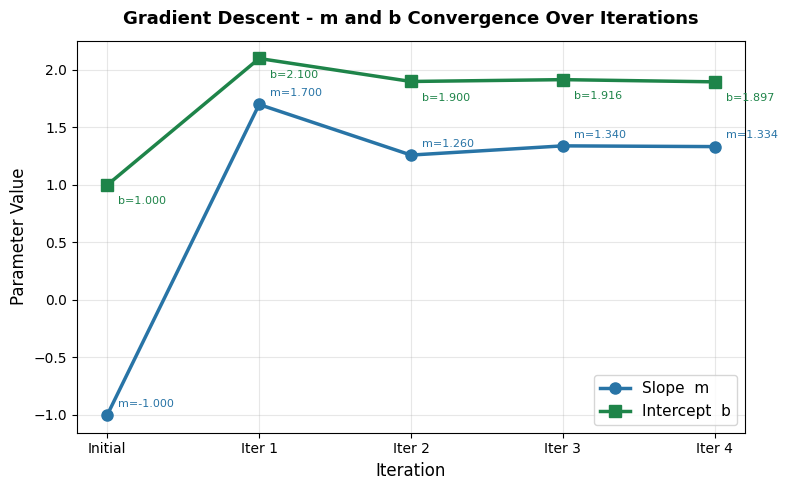

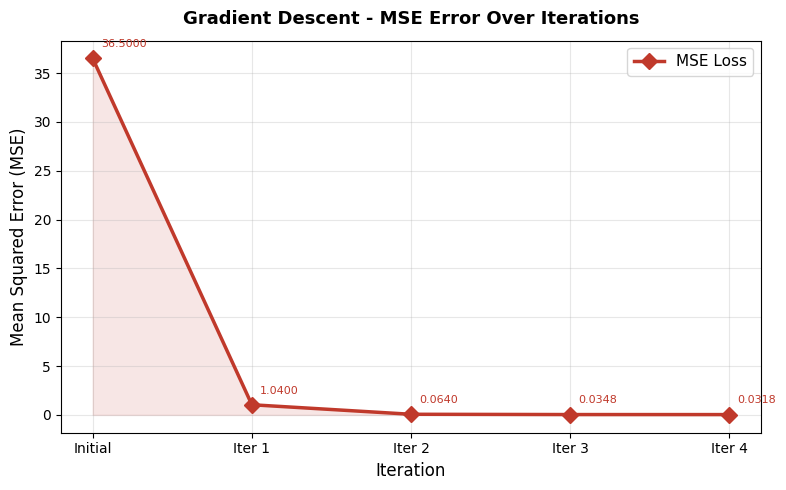

In [91]:
iters = list(range(num_iterations + 1))


fig1, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(iters, history_m, color="#2874A6", linewidth=2.5,
         marker='o', markersize=8, label="Slope  m")
ax1.plot(iters, history_b, color="#1E8449", linewidth=2.5,
         marker='s', markersize=8, label="Intercept  b")


for i, (mv, bv) in enumerate(zip(history_m, history_b)):
    ax1.annotate(f"m={mv:.3f}", (i, mv), textcoords="offset points",
                 xytext=(8, 6), fontsize=8, color="#2874A6")
    ax1.annotate(f"b={bv:.3f}", (i, bv), textcoords="offset points",
                 xytext=(8, -14), fontsize=8, color="#1E8449")

ax1.set_title("Gradient Descent - m and b Convergence Over Iterations",
              fontsize=13, fontweight='bold', pad=12)
ax1.set_xlabel("Iteration", fontsize=12)
ax1.set_ylabel("Parameter Value", fontsize=12)
ax1.set_xticks(iters)
ax1.set_xticklabels([f"Iter {i}" if i > 0 else "Initial" for i in iters])
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



fig2, ax2 = plt.subplots(figsize=(8, 5))

ax2.plot(iters, history_error, color="#C0392B", linewidth=2.5,
         marker='D', markersize=8, label="MSE Loss")
ax2.fill_between(iters, history_error, alpha=0.12, color="#C0392B")


for i, ev in enumerate(history_error):
    ax2.annotate(f"{ev:.4f}", (i, ev), textcoords="offset points",
                 xytext=(6, 8), fontsize=8, color="#C0392B")

ax2.set_title("Gradient Descent - MSE Error Over Iterations",
              fontsize=13, fontweight='bold', pad=12)
ax2.set_xlabel("Iteration", fontsize=12)
ax2.set_ylabel("Mean Squared Error (MSE)", fontsize=12)
ax2.set_xticks(iters)
ax2.set_xticklabels([f"Iter {i}" if i > 0 else "Initial" for i in iters])
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Key Insights:

**Visual Interpretation:**

*Plot 1 (Parameter Convergence):*
- The steep curve for m in the first iteration visualizes the dramatic correction from negative to positive slope
- Both parameters show asymptotic behavior, approaching stable values without oscillating wildly
- The convergence of m and b at different rates shows they are optimized semi-independently through partial derivatives (∂J/∂m and ∂J/∂b)

*Plot 2 (MSE Convergence):*
- The exponential decay curve is characteristic of successful gradient descent on a convex cost function
- The flattening curve after 4 iterations suggests we're approaching the global minimum
- The rate of error reduction slows with each iteration, indicating diminishing returns—further iterations would yield minimal improvement